# Music Generation with Deep Learning

### Music characteristics:

* Pitch
* Duration
* Step
* Octave

## Imports

In [1]:
!pip3 install keras-visualizer
import sys, os, random, IPython, warnings, music21
from music21 import *
from IPython.display import Image, Audio
from collections import Counter
warnings.filterwarnings("ignore")
from keras_visualizer import visualizer 
warnings.simplefilter("ignore")
from music21 import note
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
np.random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Mount Google Drive 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Data

To accomplish this project, we are initially using MIDI files of classical piano music, to be more precise: <ins>**Beethoven's compositions**</ins>.

- Initially, we will generate a list comprising every song in the **Beethoven** folder,parsed as a *music21* stream.

- Later, we will create a function to extract both chords and notes from the data, transforming it into a **corpus**.

### Get MIDI music files

In [2]:
cwd = os.getcwd()
fileHalsey = cwd + "/drive/MyDrive/input/Halsey_music"
fileBeethoven = cwd + "/drive/MyDrive/input/classical-music/beeth"
filepath = fileBeethoven

all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        print(i)
        tr = filepath+"/"+i
        midi = converter.parse(tr)
        all_midis.append(midi)

beethoven_opus10_1.mid
beethoven_opus10_2.mid
beethoven_opus10_3.mid
pathetique_1.mid
pathetique_3.mid
pathetique_2.mid
beethoven_opus22_1.mid
beethoven_opus22_2.mid
beethoven_opus22_3.mid
beethoven_opus22_4.mid
mond_1.mid
mond_2.mid
mond_3.mid
waldstein_1.mid
waldstein_2.mid
waldstein_3.mid
appass_1.mid
appass_2.mid
appass_3.mid
beethoven_les_adieux_1.mid
beethoven_les_adieux_2.mid
beethoven_les_adieux_3.mid
beethoven_hammerklavier_1.mid
beethoven_hammerklavier_2.mid
beethoven_hammerklavier_3.mid
beethoven_hammerklavier_4.mid
elise.mid
beethoven_opus90_1.mid
beethoven_opus90_2.mid


### Get the list of notes as corpus

Next, we will extract the elements from these MIDI file streams. The dataset specifies that the MIDI files exclusively contain piano recordings. Hence, the extracted components will consist of either piano chords or individual piano notes.

<ins>Difference between notes and chords:</ins>

- **[NOTE]** The musical notes serve as the building blocks of music, representing pitches associated to distinct audio vibrations. Notably, Western music employs a set of 12 musical notes.

- **[CHORD]** A collection of harmonious notes.

The previously created music21 stream in the preceding cell contains a mixture of chords and notes. Our **goal** is to extract them specifically as individual notes, resulting in <ins>a series of notes forming the musical composition</ins>.

In [5]:
def extract_notes(file):
    pitches = []
    durations = []
    steps = []
    octaves = []
    pick = None

    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    pitches.append(str(element.pitch))
                    durations.append(element.duration.quarterLength)
                    steps.append(str(element.pitch.step))
                    octaves.append(str(element.pitch.octave))
                elif isinstance(element, chord.Chord):
                    pitches.append(".".join(str(n) for n in element.normalOrder))
                    durations.append(element.duration.quarterLength)
                    chord_steps = str(min(element.pitches).step)
                    chord_octave = str(min(element.pitches).octave)
                    steps.append(chord_steps)
                    octaves.append(chord_octave)

    return pitches, durations, steps, octaves

Corpus_pitches, Corpus_durations, Corpus_steps, Corpus_octaves = extract_notes(all_midis)

## Data Processing

Notes can be understood as sound waves. In music, we have specific combinations of frequency and wavelength that are standardized as notes. In our corpus, we have the names of these notes. When we loaded the data using the *music21* library, it provided us with the **frequency**, **wavelength**, **duration**, and other information for each note.

### Create corpus's mapping and reverse mapping

We will create a dictionary to establish a mapping between the notes and their corresponding indices. Since computers perceive these note names as symbols, we need this dictionary to associate each unique note in our corpus with a specific number. This mapping will be used to encode and decode information when interacting with the RNN.

In [6]:
symb_notes = sorted(list(set(Corpus_pitches))) 
symb_durations = sorted(list(set(Corpus_durations))) 
symb_steps = sorted(list(set(Corpus_steps))) 
symb_octaves = sorted(list(set(Corpus_octaves))) 

L_pitches = len(Corpus_pitches) 
L_durations = len(Corpus_durations)  
L_steps = len(Corpus_steps)  
L_octaves = len(Corpus_octaves)  

L_symb_notes = len(symb_notes) 
L_symb_durations = len(symb_durations) 
L_symb_steps = len(symb_steps)
L_symb_octaves = len(symb_octaves)

mapping_notes = dict((c, i) for i, c in enumerate(symb_notes))  
mapping_durations = dict((c, i) for i, c in enumerate(symb_durations))  
mapping_steps = dict((c, i) for i, c in enumerate(symb_steps)) 
mapping_octaves = dict((c, i) for i, c in enumerate(symb_octaves)) 

reverse_mapping_notes = dict((i, c) for i, c in enumerate(symb_notes)) 
reverse_mapping_durations = dict((i, c) for i, c in enumerate(symb_durations))
reverse_mapping_steps = dict((i, c) for i, c in enumerate(symb_steps))
reverse_mapping_octaves = dict((i, c) for i, c in enumerate(symb_octaves))

print("Total number of notes: ", L_pitches)
print("Number of unique notes: ", L_symb_notes)
print("\n")
print("Total number of durations: ", L_durations)
print("Number of unique durations: ", L_symb_durations)
print("\n")
print("Total number of steps: ", L_steps)
print("Number of unique steps: ", L_symb_steps)
print("\n")
print("Total number of octaves: ", L_octaves)
print("Number of unique octaves: ", L_symb_octaves)

Total number of notes:  81312
Number of unique notes:  349


Total number of durations:  81312
Number of unique durations:  33


Total number of steps:  81312
Number of unique steps:  7


Total number of octaves:  81312
Number of unique octaves:  7


In [7]:
count_num = Counter(Corpus_pitches)

rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times: ", len(rare_note))

Total number of notes that occur less than 100 times:  215


### Get a list of rare notes

The **existence of rare notes** in the corpus can potentially lead to numerous issues, encountered while composing this piece. To prevent encountering error reports, let's examine the frequency of the notes. For the sake of simplicity, we will exclude some of the least occurring notes.

In [8]:
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times: ", len(rare_note))

Total number of notes that occur less than 100 times:  215


### Eliminate the rare notes

In [9]:
"""for element in Corpus_pitches:
    if element in rare_note:
        Corpus_pitches.remove(element)

print("Length of corpus after elemination the rare notes: ", len(Corpus_pitches))"""

'for element in Corpus_pitches:\n    if element in rare_note:\n        Corpus_pitches.remove(element)\n\nprint("Length of corpus after elemination the rare notes: ", len(Corpus_pitches))'

### Replace the removed notes with the most frequent one

In [10]:
frequent_notes = []
for note, count in count_num.items():
    if count >= 100:
        frequent_notes.append(note)

for i in range(len(Corpus_pitches)):
    if Corpus_pitches[i] in rare_note:
        Corpus_pitches[i] = max(frequent_notes, key=lambda x: count_num[x])

print("Length of corpus after replacing the rare notes: ", len(Corpus_pitches))

Length of corpus after replacing the rare notes:  81312


### Encode the corpus as labels and targets

We will encode the corpus by converting it into smaller sequences of equal length. Each sequence will consist of both the features and the corresponding targets. The features and targets will be represented by the mapped indices from the dictionary, indicating unique characters.

In [11]:
length = 40

note_features = []
duration_features = []
step_features = []
octave_features = []

note_targets = []
duration_targets = []
step_targets = []
octave_targets = []

for i in range(0, L_pitches - length, 1):
    note_feature = Corpus_pitches[i:i + length]
    duration_feature = Corpus_durations[i:i + length]
    step_feature = Corpus_steps[i:i + length]
    octave_feature = Corpus_octaves[i:i + length]

    target_note = Corpus_pitches[i + length]
    target_duration = Corpus_durations[i + length]
    target_step = Corpus_steps[i + length]
    target_octave = Corpus_octaves[i + length]

    note_features.append([mapping_notes[j] for j in note_feature])
    duration_features.append([mapping_durations[k] for k in duration_feature])
    step_features.append([mapping_steps[q] for q in step_feature])
    octave_features.append([mapping_octaves[p] for p in octave_feature])

    note_targets.append(mapping_notes[target_note])
    duration_targets.append(mapping_durations[target_duration])
    step_targets.append(mapping_steps[target_step])
    octave_targets.append(mapping_octaves[target_octave])

L_datapoints = len(note_targets)
print("Total number of sequences in the corpus: ", L_datapoints)

Total number of sequences in the corpus:  81272


### Reshape sequences to be in the format of model input

The <ins>labels</ins> will be **reshaped** and **normalized**, while the <ins>targets</ins> themselves will be **one-hot encoded**. These processed inputs will be fed into the RNN for training. However, before that, we need to build the RNN model.

In [12]:
note_features = (np.reshape(note_features, (L_datapoints, length, 1))) / float(L_symb_notes)
duration_features = (np.reshape(duration_features, (L_datapoints, length, 1))) / float(L_symb_durations)
step_features = (np.reshape(step_features, (L_datapoints, length, 1))) / float(L_symb_steps)
octave_features = (np.reshape(octave_features, (L_datapoints, length, 1))) / float(L_symb_octaves)

note_targets = tensorflow.keras.utils.to_categorical(note_targets)
duration_targets = tensorflow.keras.utils.to_categorical(duration_targets)
step_targets = tensorflow.keras.utils.to_categorical(step_targets)
octave_targets = tensorflow.keras.utils.to_categorical(octave_targets)

### Split data into training and test sets

To generate music, we will need to provide some input to the RNN. For this purpose, we will set aside a portion of the data as "seeds." Although we could have trained the model using the entire dataset, as non-musicians, we are not capable of coming up with a suitable input seed value.

In [13]:

X_note_train, X_note_test, X_duration_train, X_duration_test, X_step_train, X_step_test, X_octave_train, X_octave_test, y_target_note_train, y_target_note_test, y_target_duration_train, y_target_duration_test, y_target_step_train, y_target_step_test, y_target_octave_train, y_target_octave_test= train_test_split(
    note_features, duration_features, step_features, octave_features, note_targets, duration_targets, step_targets, octave_targets, test_size=0.2, random_state=42
)


## Build Model

In [14]:
note_input = Input(shape=(X_note_train.shape[1], X_note_train.shape[2]))
duration_input = Input(shape=(X_duration_train.shape[1], X_duration_train.shape[2]))
step_input = Input(shape=(X_step_train.shape[1], X_step_train.shape[2]))
octave_input = Input(shape=(X_octave_train.shape[1], X_octave_train.shape[2]))

note_branch = LSTM(256, return_sequences=True)(note_input)
note_branch = Dropout(0.1)(note_branch)
note_branch = LSTM(128)(note_branch)

duration_branch = LSTM(256, return_sequences=True)(duration_input)
duration_branch = Dropout(0.1)(duration_branch)
duration_branch = LSTM(128)(duration_branch)

step_branch = LSTM(256, return_sequences=True)(step_input)
step_branch = Dropout(0.1)(step_branch)
step_branch = LSTM(128)(step_branch)

octave_branch = LSTM(256, return_sequences=True)(octave_input)
octave_branch = Dropout(0.1)(octave_branch)
octave_branch = LSTM(128)(octave_branch)

merged = Concatenate()([note_branch, duration_branch, step_branch, octave_branch])
merged = Dense(128)(merged)
merged = Dropout(0.1)(merged)

output_note = Dense( y_target_note_train.shape[1], activation='softmax')(merged)
output_duration = Dense( y_target_duration_train.shape[1], activation='softmax')(merged)
output_step = Dense( y_target_step_train.shape[1], activation='softmax')(merged)
output_octave = Dense( y_target_octave_train.shape[1], activation='softmax')(merged)

model = Model(inputs=[note_input, duration_input, step_input, octave_input], outputs=[output_note, output_duration, output_step, output_octave])

opt = tf.keras.optimizers.Adamax(learning_rate=0.01)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
              optimizer=opt,
              metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40, 1)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 40, 1)]      0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 40, 1)]      0           []                               
                                                                                              

## Train model

In [16]:
# BATCH_SIZE for Halsey is set for 128
# history = model.fit([X_note_train, X_duration_train], [y_target_note_train, y_target_duration_train], batch_size=128, epochs=150)
# BATCH_SIZE for Beethoven is set for 400
history = model.fit([X_note_train, X_duration_train, X_step_train, X_octave_train], [y_target_note_train, y_target_duration_train, y_target_step_train, y_target_octave_train], batch_size=400, epochs=150)

Epoch 1/150
163/163 [==============================] - 15s 90ms/step - loss: 6.9546 - dense_1_loss: 3.4189 - dense_2_loss: 0.7671 - dense_3_loss: 1.7044 - dense_4_loss: 1.0643 - dense_1_accuracy: 0.1825 - dense_2_accuracy: 0.7702 - dense_3_accuracy: 0.3257 - dense_4_accuracy: 0.5828
Epoch 2/150
163/163 [==============================] - 15s 90ms/step - loss: 6.8000 - dense_1_loss: 3.3261 - dense_2_loss: 0.7489 - dense_3_loss: 1.6839 - dense_4_loss: 1.0410 - dense_1_accuracy: 0.1993 - dense_2_accuracy: 0.7751 - dense_3_accuracy: 0.3341 - dense_4_accuracy: 0.5930
Epoch 3/150
163/163 [==============================] - 15s 90ms/step - loss: 6.6527 - dense_1_loss: 3.2389 - dense_2_loss: 0.7327 - dense_3_loss: 1.6617 - dense_4_loss: 1.0194 - dense_1_accuracy: 0.2144 - dense_2_accuracy: 0.7788 - dense_3_accuracy: 0.3462 - dense_4_accuracy: 0.6029
Epoch 4/150
163/163 [==============================] - 15s 91ms/step - loss: 6.4864 - dense_1_loss: 3.1441 - dense_2_loss: 0.7147 - dense_3_loss: 1.

## Evaluating models

Having completed the training of our model using the MIDI files of piano music, it's time to evaluate its performance and observe the results.

### Plot the learning curve for the loss function

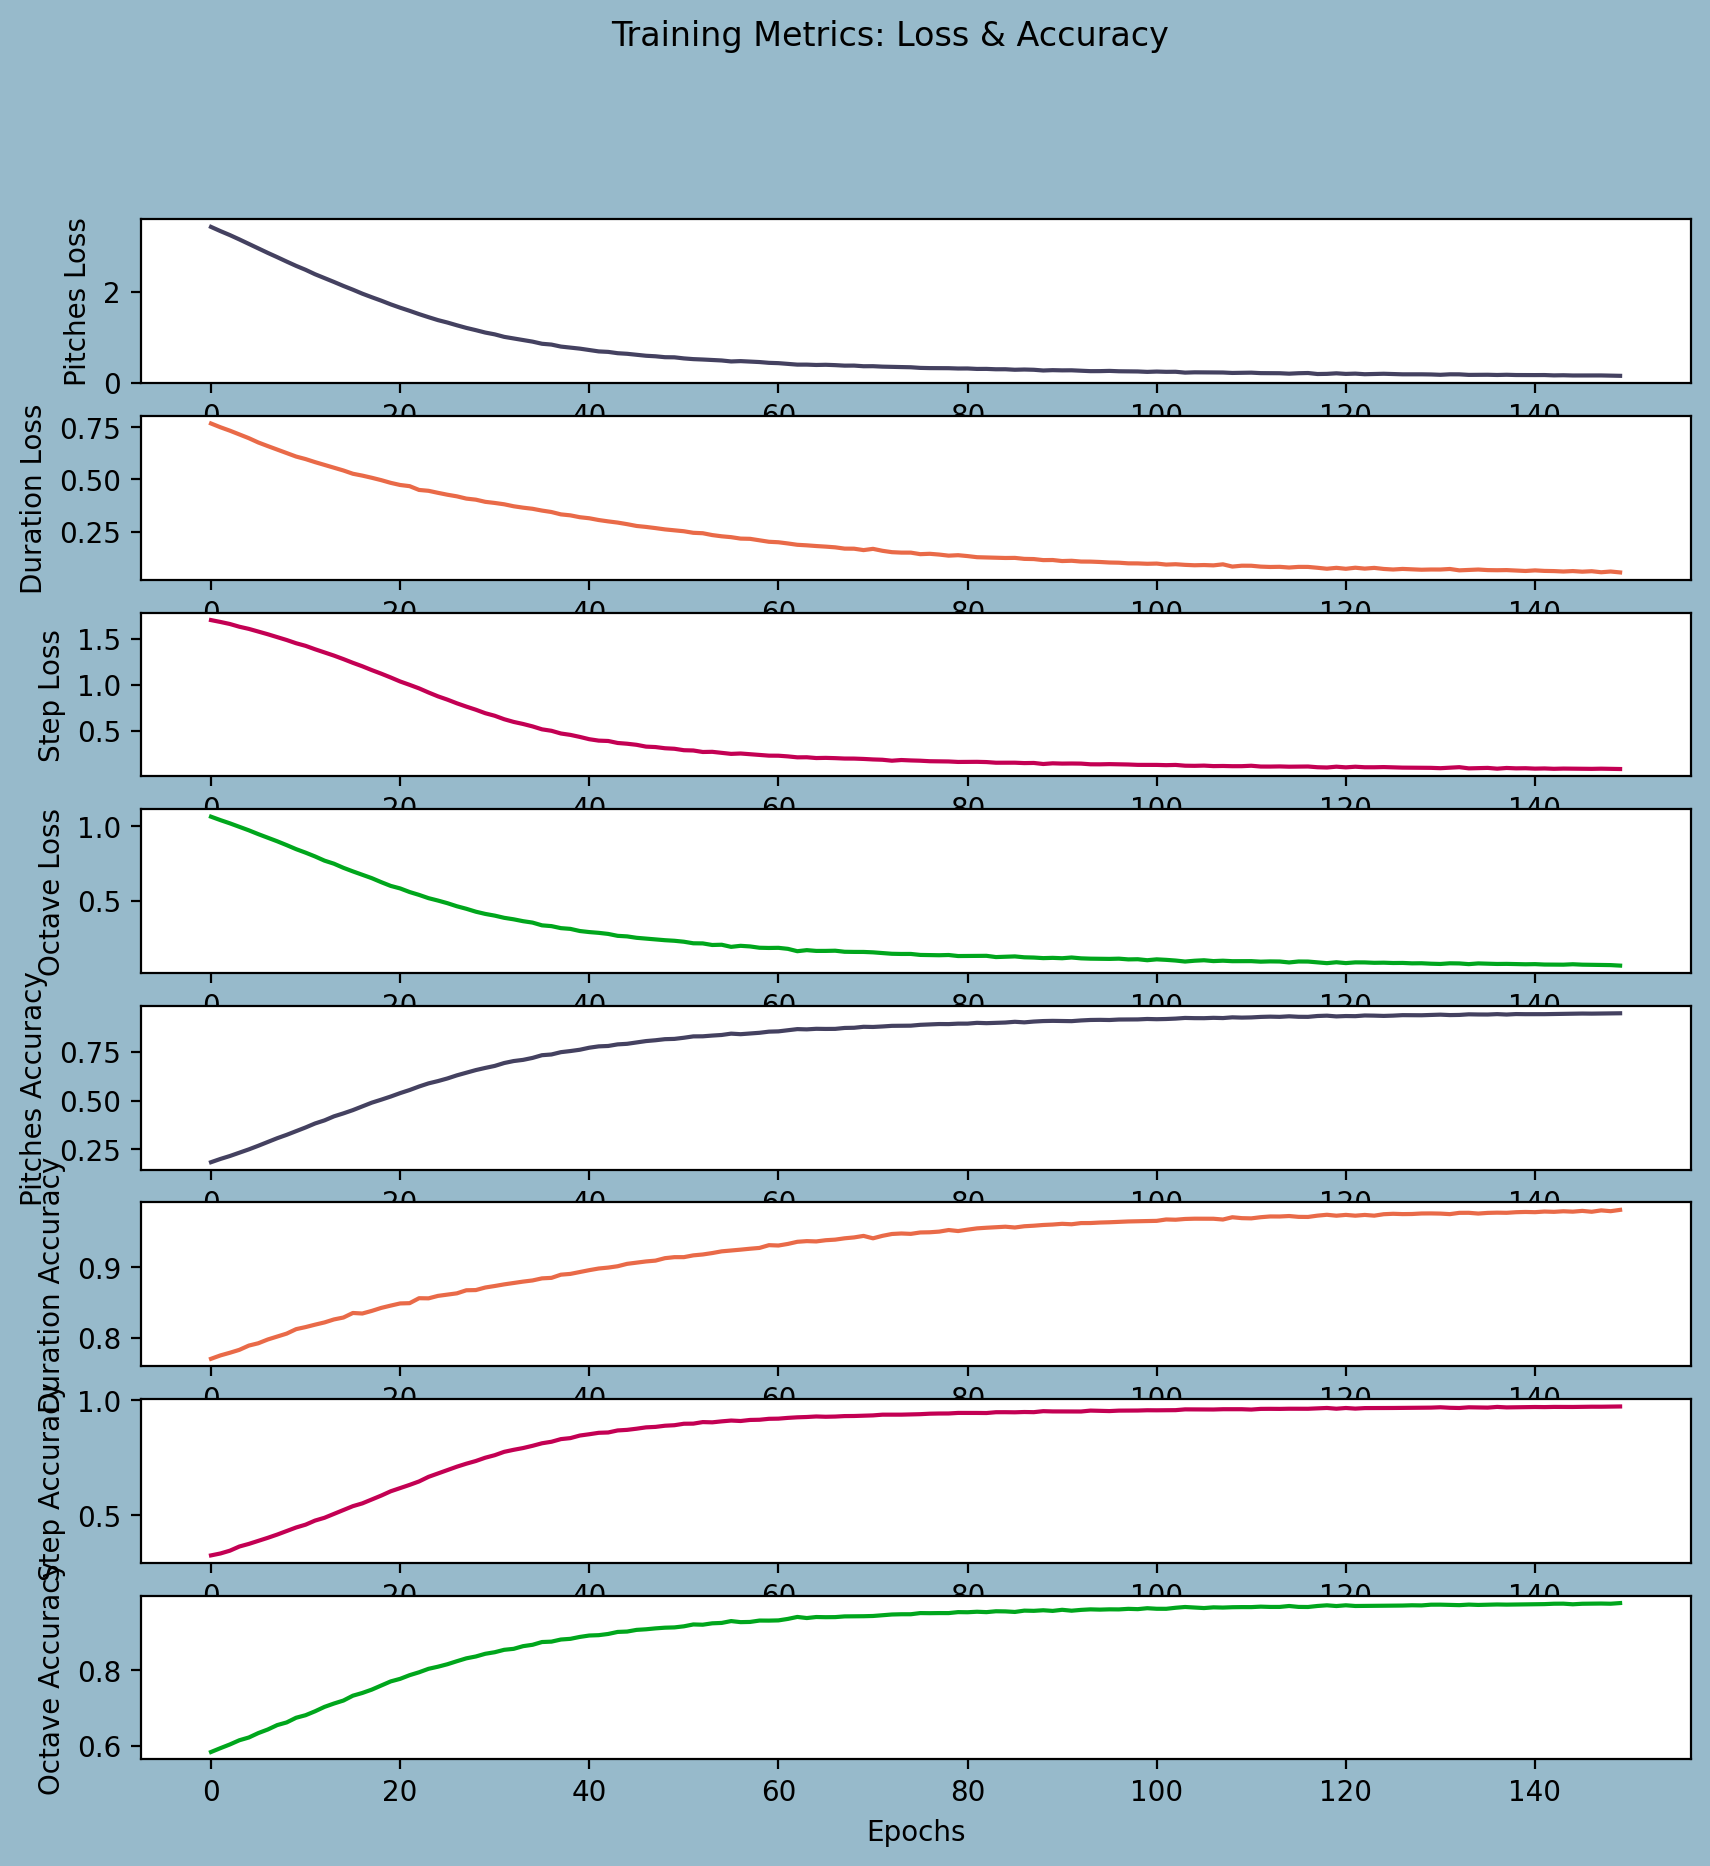

In [18]:
history_df = pd.DataFrame(history.history)

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 1, figsize=(10, 10), facecolor="#97BACB")
fig.suptitle("Training Metrics: Loss & Accuracy")

# Plot Pitches Loss
sns.lineplot(data=history_df["dense_1_loss"], color="#444160", ax=ax1)
ax1.set_ylabel("Pitches Loss")
ax1.set_xlabel("Epochs")

# Plot Duration Loss
sns.lineplot(data=history_df["dense_2_loss"], color="#E96A48", ax=ax2)
ax2.set_ylabel("Duration Loss")
ax2.set_xlabel("Epochs")

# Plot Step Loss
sns.lineplot(data=history_df["dense_3_loss"], color="#C30053", ax=ax3)
ax3.set_ylabel("Step Loss")
ax3.set_xlabel("Epochs")

# Plot Octave Loss
sns.lineplot(data=history_df["dense_4_loss"], color="#00A61C", ax=ax4)
ax4.set_ylabel("Octave Loss")
ax4.set_xlabel("Epochs")

# Plot Pitches Accuracy
sns.lineplot(data=history_df["dense_1_accuracy"], color="#444160", ax=ax5)
ax5.set_ylabel("Pitches Accuracy")
ax5.set_xlabel("Epochs")

# Plot Duration Accuracy
sns.lineplot(data=history_df["dense_2_accuracy"], color="#E96A48", ax=ax6)
ax6.set_ylabel("Duration Accuracy")
ax6.set_xlabel("Epochs")

# Plot Step Accuracy
sns.lineplot(data=history_df["dense_3_accuracy"], color="#C30053", ax=ax7)
ax7.set_ylabel("Step Accuracy")
ax7.set_xlabel("Epochs")

# Plot Octave Accuracy
sns.lineplot(data=history_df["dense_4_accuracy"], color="#00A61C", ax=ax8)
ax8.set_ylabel("Octave Accuracy")
ax8.set_xlabel("Epochs")

plt.show()

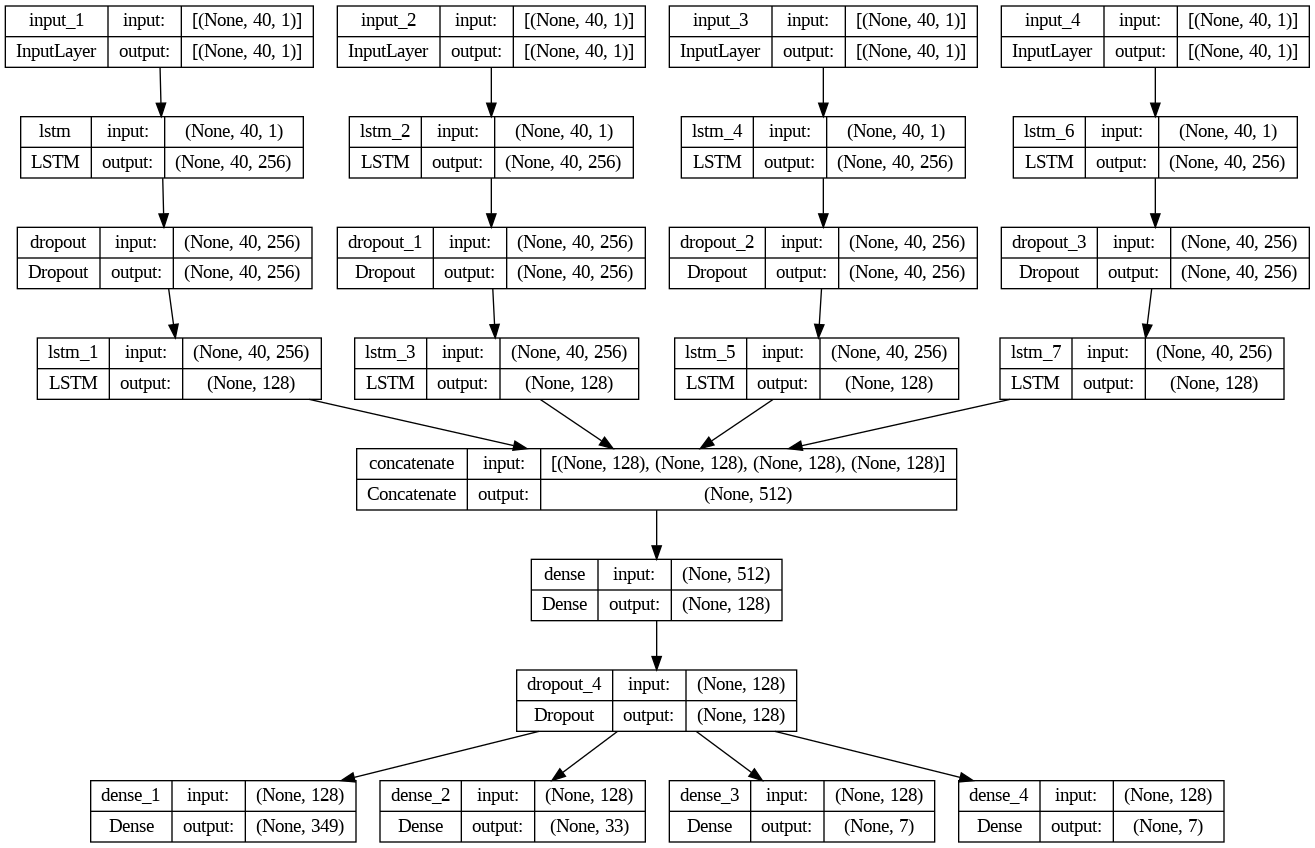

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='/content/model_architecture.png', show_shapes=True, show_layer_names=True)

### Generating the melody

The idea is to have music in form or a list of chords and notes so that we can convert it into a midi file.

In [20]:
def chords_n_notes(Snippet_notes, Snippet_durations, Snippet_steps, Snippet_octaves):
    Melody = []
    offset = 0

    for note_val, duration_val, step_val, octave_val in zip(Snippet_notes, Snippet_durations, Snippet_steps, Snippet_octaves):
        
        # in case it is a chord
        if ("." in note_val or note_val.isdigit()):
            chord_notes = note_val.split(".")
            notes = [] 
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note()
                note_snip.pitch.midi = inst_note
                note_snip.duration = duration.Duration(duration_val)
                note_snip.duration.quarterLength = duration_val
                note_snip.step = step_val
                note_snip.octave = octave_val
                notes.append(note_snip)
            chord_snip = chord.Chord(notes)
            chord_snip.offset = offset
            Melody.append(chord_snip)
        
        # in case it is a note
        else: 
            note_snip = note.Note(note_val)
            note_snip.offset = offset
            note_snip.duration.quarterLength = duration_val
            note_snip.step = step_val
            note_snip.octave = octave_val
            Melody.append(note_snip)

        offset += duration_val

    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

In [21]:

def Melody_Generator(Note_Count):
    seed_pitches = X_note_test[np.random.randint(0, len(X_note_test) - 1)]
    seed_durations = X_duration_test[np.random.randint(0, len(X_duration_test) - 1)]
    seed_steps = X_step_test[np.random.randint(0, len(X_step_test) - 1)]
    seed_octaves = X_octave_test[np.random.randint(0, len(X_octave_test) - 1)]

    Music = []
    Pitches_Generated = []
    Durations_Generated = []
    Steps_Generated = []
    Octaves_Generated = []

    for i in range(Note_Count):
        seed_pitches_reshaped = seed_pitches.reshape(1, length, 1)
        seed_durations_reshaped = seed_durations.reshape(1, length, 1)
        seed_steps_reshaped = seed_steps.reshape(1, length, 1)
        seed_octaves_reshaped = seed_octaves.reshape(1, length, 1)
        
        prediction_pitches, prediction_durations, prediction_steps, prediction_octaves = model.predict([seed_pitches_reshaped, seed_durations_reshaped, seed_steps_reshaped, seed_octaves_reshaped], verbose=0)
        
        prediction_pitches = np.log(prediction_pitches) / 1.0
        prediction_durations = np.log(prediction_durations) / 1.0
        prediction_steps = np.log(prediction_steps) / 1.0
        prediction_octaves = np.log(prediction_octaves) / 1.0
        
        exp_preds_pitches = np.exp(prediction_pitches)
        exp_preds_durations = np.exp(prediction_durations)
        exp_preds_steps = np.exp(prediction_steps)
        exp_preds_octaves = np.exp(prediction_octaves)
        
        prediction_pitches = exp_preds_pitches / np.sum(exp_preds_pitches)
        prediction_durations = exp_preds_durations / np.sum(exp_preds_durations)
        prediction_steps = exp_preds_steps / np.sum(exp_preds_steps)
        prediction_octaves = exp_preds_octaves / np.sum(exp_preds_octaves)

        index_pitch = np.argmax(prediction_pitches)
        index_duration = np.argmax(prediction_durations)
        index_step = np.argmax(prediction_steps)
        index_octave = np.argmax(prediction_octaves)
        
        index_N_pitch = index_pitch / float(L_symb_notes)
        index_N_duration = index_duration / float(L_symb_durations)
        index_N_step = index_step / float(L_symb_steps)
        index_N_octave = index_octave / float(L_symb_octaves)
        
        Pitches_Generated.append(index_pitch)
        Durations_Generated.append(index_duration)
        Steps_Generated.append(index_step)
        Octaves_Generated.append(index_octave)
        
        Music_pitches = [reverse_mapping_notes[char] for char in Pitches_Generated]
        Music_durations = [reverse_mapping_durations[char] for char in Durations_Generated]
        Music_steps = [reverse_mapping_steps[char] for char in Steps_Generated]
        Music_octaves = [reverse_mapping_octaves[char] for char in Octaves_Generated]
        
        Music = chords_n_notes(Music_pitches, Music_durations, Music_steps, Music_octaves)
        
        seed_pitches = np.insert(seed_pitches, len(seed_pitches), index_N_pitch)
        seed_pitches = seed_pitches[1:]
        
        seed_durations = np.insert(seed_durations, len(seed_durations), index_N_duration)
        seed_durations = seed_durations[1:]

        seed_steps = np.insert(seed_steps, len(seed_steps), index_N_step)
        seed_steps = seed_steps[1:]

        seed_octaves = np.insert(seed_octaves, len(seed_octaves), index_N_octave)
        seed_octaves = seed_octaves[1:]
    
    Melody_midi = stream.Stream(Music)
    return Music_pitches, Music_durations, Music_steps, Music_octaves, Melody_midi

In [22]:
from music21 import note, chord

In [23]:
Music_pitches, Music_durations, Music_steps, Music_octaves, Melody = Melody_Generator(100)

In [24]:
cwd = os.getcwd()
filepath = cwd + "/drive/MyDrive/"
filename = 'beeth.h5'
model.save(filepath + filename)

In [26]:
cwd = os.getcwd()
filepath = cwd + "/drive/MyDrive/"
filename = 'Melody_Generated_Beeth_With_Octave.mid'
Melody.write('midi',filepath + filename)

'/content/drive/MyDrive/Melody_Generated_Beeth_With_Octave_2.mid'